In [2]:
from os.path import exists
import requests
from typing import *
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats as stats

import numpy as np
import pandas as pd
from tqdm.notebook import trange, tqdm

# Notebook 2: Probability and Linear Regression

## Problem 1: A Strange Regression Model

Suppose we are fitting a regression model to a dataset $(x_i, y_i)_{1 \leq i \leq N}$
\begin{align*}
p(y^i|x^i; \theta) & = \mathcal{N}(f_1(x_1^i) \theta_1 + f_2(x_2^i) \theta_2 + \theta_3, 1) \\
p(y |x; \theta) & = \prod_{i=1}^N p(y^i|x^i; \theta)
\end{align*}
where
1. the inputs $x^i \in \mathbb{R}^2$ are 2-D vectors
2. $f_1, f_2, f_3: \mathbb{R} \rightarrow \mathbb{R}$ are arbitrary functions.
3. $\theta = (\theta_1, \theta_2, \theta_3)$ is a vector of weights

### Problem 1a

Implement the conditional density given below.

In [3]:
# Scout resources to verify correctness of the implementation.

x1 = [2., 2.]
x2 = [3., 4.]
x3 = [5., 6.]

x = np.array([x1, x2, x3])
Y = np.array([7., 13., 30.])
try_theta = np.array([.3, .67, .25])
actual_thetas = [1.0, 0.5, 2.]

def f1(x: float) -> float:
    return x**2

def f2(x: float) -> float:
    return x

In [8]:
def model1_density(f1: Callable[[float], float], f2: Callable[[float], float], theta: np.ndarray, x: np.ndarray) -> Callable[[np.ndarray], float]:
    # f1 is function f_1
    # f2 is function f_2
    # theta is some choice of weights
    # x is an input
    # y: length N vector

    x_new = np.concatenate([x, np.ones((x.shape[0], 1))], axis=1)
    x_new[:, 0] = f1(x_new[:, 0])
    x_new[:, 1] = f2(x_new[:, 1])

    normals = [ stats.norm(loc= theta @ x_new[i], scale=1) for i in range(x_new.shape[0]) ]

    #conditional_density = normals[0].pdf(Y[0]) * normals[1].pdf(Y[1]) * normals[2].pdf(Y[2])

    return lambda y: np.prod([normals[i].pdf(y[i]) for i in range(len(y))])

In [9]:
density = model1_density(f1, f2, try_theta, x)

print(density(Y))

9.864009903343106e-90


### Problem 1b

Write a function that solves for the weights by finding the approximate minimum of the conditional density, i.e., solve
$$
\operatorname{argmin}_{\theta} -p(y | x; \theta)
$$
1. The input $X^{N \times 2}$ is a $N \times 2$ matrix where row $i$ of the matrix contains the input $x^i$.
2. The input $Y^N$ is a length $N$ vector where each entry contains the corresponding value $y^i$.

In [5]:
def solve_for_weights(f1: Callable[[float], float], f2: Callable[[float], float], X: np.ndarray, Y: np.ndarray) -> np.ndarray:
    
    thetaspace = np.linspace(0., 12.0, 100)

    best_density = 0.
    best_theta = np.array([1.5, .25, 0])
    
    for theta3 in tqdm(thetaspace):
        theta = np.array([best_theta[0], best_theta[1], theta3])
        density_f = model1_density(f1, f2, theta, x)
        density = density_f(Y)
        if density > best_density:
            best_density = density
            best_theta[2] = theta3

    for theta2 in tqdm(thetaspace):
        for theta1 in thetaspace:
            theta = np.array([theta1, theta2, best_theta[2]])
            density_f = model1_density(f1, f2, theta, x)
            density = density_f(Y)
            if density > best_density:
                best_density = density
                best_theta[0] = theta1
                best_theta[1] = theta2

    return best_theta

grid_thetas = solve_for_weights(f1, f2, x, Y)

print("Thetas obatained from grid search: " + str(grid_thetas))

density_f = model1_density(f1, f2, grid_thetas, x)
density = density_f(Y)
print("Probability density based on these thetas: " + str(density))

#can try plotting the density or set functions as identity functions: x comonents themselves

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Thetas obatained from grid search: [0.84848485 1.45454545 0.        ]
Probability density based on these thetas: 0.04483163226933461


### Problem 1c

Transform the probabilistic model into a system that can be solved with linear algebra.
```ts
def linear_algebra_solve(X, Y):
    X_p = np.concatenate([X, np.ones((Y.size[0], 1))], axis=1)
    return np.linalg.solve(X_p.transpose() @ X_p, X_p.transpose() @ Y)
```
That is, come up with new matrix $X'$ and vector $Y'$ such that it can be input into `linear_algebra_solve`ts to produce the same set of weights.


In [6]:
def transform(f1: Callable[[float], float], f2: Callable[[float], float], X: np.ndarray, Y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    
    # X is a matrix of inputs
    # Y is a vector of outputs

    # return a new X and Y

    new_X = np.array([f1(x[:, 0]), f2(x[:, 1])]).T
    #new_Y = Y

    return new_X, Y

def linear_algebra_solve(X, Y):
    X_p = np.concatenate([X, np.ones((X.shape[0], 1))], axis=1)
    return np.linalg.solve(X_p.transpose() @ X_p, X_p.transpose() @ Y)

las_X, las_Y = transform(f1, f2, x, Y)
linalg_thetas = linear_algebra_solve(las_X, las_Y)

print("Thetas obtained from linear algebra: " + str(linalg_thetas))

linalg_density_f = model1_density(f1, f2, linalg_thetas, x)

print("Probability density based on these thetas: " + str(linalg_density_f(Y)))

Thetas obtained from linear algebra: [1.  0.5 2. ]
Probability density based on these thetas: 0.06349363593424098


## Problem 2: Mixture Model

Suppose that we are performing regression in a setting with the following density
$$
p(y|x; \theta, \beta) = \frac{1}{2}p_1(y|x; \theta) + \frac{1}{2}p_2(y|x; \beta)
$$
where both $p_1(y|x; \theta)$ and $p_2(y|x; \theta)$ are linear regressions.

### Problem 2a

Write a function that generates synthetic data according to the following probabilistic model.
\begin{align*}
z^i & \sim Bern(0.5) \\
y^i & \sim \begin{cases}
\mathcal{N}(\theta x^i, 1) & \mbox{when $z^i = 0$} \\
\mathcal{N}(\beta x^i, 1) & \mbox{when $z^i = 1$}
\end{cases}
\end{align*}
In this example, we are assuming that the inputs are a single real number.

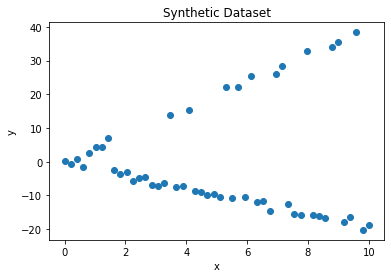

In [7]:
def generate_dataset(theta: float, beta: float, x: np.ndarray) -> np.ndarray:
    # X is a length N array
    # Return N y's as a np.
    
    bern = sp.stats.bernoulli(0.5)
    z = bern.rvs(size=50)

    z0 = lambda x: stats.norm(loc=theta * x, scale=1)
    z1 = lambda x: stats.norm(loc=beta * x, scale=1)

    y = np.array([z0(x[i]).rvs() if z[i] == 0 else z1(x[i]).rvs() for i in range(len(x))])

    #for i in range(len(z)):
    #    if z[i] == 0:
    #        y[i] = z0(x[i])
    #    else: y[i] = z1(x[i])

    return y

#let's try plotting the y values

x_mm = np.linspace(0, 10, 50)
y_mm = generate_dataset(-2, 4, x_mm)

plt.scatter(x_mm, y_mm)
plt.title('Synthetic Dataset')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### Problem 2b

Write a function that implements the conditional density
$$
p(y | x; \theta, \beta)
$$
assuming that each $y^i$ is conditionally independent of each other given $z_i$.


In [8]:
def mixture_model_density(theta: float, beta: float, X: np.ndarray, y: np.ndarray) -> float:
    # X is a one dimensional array of x values, N
    # dim(y) = dim(x)

    normals0 = []
    normals1 = []

    normals0 = [ stats.norm(loc=np.dot(theta, X[i]), scale=1) for i in range(X.shape[0]) ]
    normals1 = [ stats.norm(loc=np.dot(beta, X[i]), scale=1) for i in range(X.shape[0]) ]

    #for i in range(x.shape[0]):

    return np.prod([(0.5 * normals0[i].pdf(y[i]) + 0.5 * normals1[i].pdf(y[i])) for i in range(len(y))])

### Problem 2c

Write a function that finds the optimal parameters of $\theta$ and $\beta$, i.e., 
$$
\operatorname{argmin}_{\theta} p(y | x; \theta, \beta) \,.
$$
You can use `generate_dataset` to test if your code is working.

In [9]:
def solve_mixture_model_density(X: np.ndarray, Y: np.ndarray) -> Tuple[float, float]:
    # X contains a length N array of inputs of dimension 1
    # Y contains a length N array of outputs
    
    best_theta = 0.0
    best_beta = 0.0
    best_density = 0.0
        
    searchspace = np.linspace(-4, 4)

    for theta in tqdm(searchspace):
        for beta in searchspace:
            density = mixture_model_density(theta, beta, X, Y)
            if density > best_density:
                best_density = density
                best_theta = theta
                best_beta = beta
    
    return best_theta, best_beta

thetas_mm = solve_mixture_model_density(x_mm, y_mm)

print("(theta, beta): " + str(thetas_mm)), print("Density based on these weights: " + str(mixture_model_density(thetas_mm[0], thetas_mm[1], x_mm, y_mm)))

  0%|          | 0/50 [00:00<?, ?it/s]

(theta, beta): (-1.8775510204081636, 4.0)
Density based on these weights: 2.9332597770789448e-43


(None, None)

## Problem 3: Linear Regression, Duplicate Data

Suppose we have a dataset $(x_i, y_i)_{1 \leq i \leq N}$.
Suppose we duplicate this dataset so that it now contains a copy of each item.
Explain in words what happens to the weights of the linear regression in terms of the linear algebra solution and in terms of the probabilistic interpretation. Compare and contrast the two solutions. You can additionally write code and give experimental evidence as well.

### Answer: 

In terms of the linear algebra solution, the weights of the linear regression should not change when the dataset is duplicated. This is because the linear algebra solution is simply a matrix multiplication, and duplicate rows in the dataset do not change the product.

In terms of the probabilistic interpretation, the weights of the linear regression should change when the dataset is duplicated. This is because the probabilistic interpretation is based on minimizing the sum of squared errors, and doubling the dataset doubles the sum of squared errors. Therefore, the weights that minimize the sum of squared errors will be different when the dataset is duplicated.

Extra Notes: 
1) Weights stay the same in both cases.
2) Loss increases with duplicate data.
3) Mean (weights) stays the same, but the variance decreases.

In [10]:
# Function: 4x+5: using 1a, theta1 = 4, theta2 = 5

x1 = [2., 1.]
x2 = [4., 1.]
x3 = [6., 1.]
x4 = [8., 1.]
x5 = [10., 1.]

x = np.array([x1, x2, x3, x4, x5])
y = [13., 21., 29., 37., 45.]

# repeat the elements of x and y 5 times

x5 = np.repeat(x, 5, axis=0)
y5 = np.repeat(y, 5, axis=0)

In [11]:
thetas = np.linalg.solve(x5.transpose() @ x5, x5.transpose() @ y5)

print("Thetas obtained from linear algebra (with duplications): " + str(thetas))

Thetas obtained from linear algebra (with duplications): [4. 5.]


In [ ]:
temp=[]
for i in range(len(coords)):
    if i not in temp:
        for j in range(i+1,len(coords)):
            c1=coords[i]
            c2=coords[j]
            C1=SkyCoord(c1[0],c1[1], frame='galactic',unit=u.deg)
            C2=SkyCoord(c2[0],c2[1], frame='galactic',unit=u.deg)
            if C1.separation(C2)<=0.005*u.deg:
                temp.append(j)
new_coords=[]
for i in range(len(coords)):
    if i in temp:
        continue
    else:
        new_coords.append(coords[i])
coords=new_coords
len(coords)